# **0-1 Knapsack with Binary Particle-Swarm Optimization (BPSO)**

## Bio-Inspired Computing
### Mikel Ignacio Barajas Martínez

### 09/12/24

𝝮

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

## 1-0 Knapsack

"A thief robbing a store wants to take the most valuable load that can be carried in a knapsack capable of carrying at most $W$ pounds of loot. The thief can choose to take any subset of $n$ items in the store. The $i$-th item is worth $v_i$ dollars and weighs $w_i$ pounds, where $v_i$ and $w_i$ are integers. Which items should the thief take?"

We call this the **1-0** knapsack since the thief can either take or leave any item. The items are discrete, so the thief cannot take a fractional amount of each item. Each item can be taken at most one time.

In [32]:
# dp solution to compare with BPSO

def knapsack(w, v, W):
    
    n = len(w)
    dp = np.zeros((n+1, W+1))
    prev = np.zeros(W+1)

    for i in range(1, n+1):

        for j in range(1, W+1):

            dp[i][j] = dp[i-1][j]

            if w[i-1] <= j and dp[i][j] < (dp[i-1][j - w[i-1]] + v[i-1]):
                dp[i][j] = dp[i-1][j-w[i-1]] + v[i-1]
                prev[j] = i

    return dp, prev

def reconstruct(dp, prev, w, v):

    n = len(w)
    W = len(dp[0])-1
    
    i = n
    j = W

    solution = []
    while i > 0 and j > 0:
        if dp[i][j] != dp[i-1][j]:
            solution.append(i-1)
            j -= w[i-1]
        i -= 1

    return solution

In [33]:
v = [750, 500, 2750, 950, 1850, 3250, 3950]
w = [25, 10, 60, 25, 15, 30, 50]
W = 100

dp, prev = knapsack(w, v, W)
solution = reconstruct(dp, prev, w, v)
best_fitness = dp[-1][-1]

print(f'max value: {dp[-1][-1] * 1000}')

print('With:')
for i in solution:
    print(f'item {i} with value {v[i] * 1000} and weight {w[i] / 10}')

max value: 9050000.0
With:
item 6 with value 3950000 and weight 5.0
item 5 with value 3250000 and weight 3.0
item 4 with value 1850000 and weight 1.5


## BPSO

In [34]:
class BPSO:

    def __init__(self, n_particles, n_items, weights, values, capacity, iterations, c1, c2, w_max, w_min, early_stop=True):
        
        # problem parameters
        self.n_particles = n_particles
        self.n_items = n_items
        self.weights = weights
        self.values = values
        self.capacity = capacity
        self.iterations = iterations
        self.early_stop = early_stop

        # acceleration coefficients
        self.c1 = c1
        self.c2 = c2

        # inertia weight
        self.w_max = w_max
        self.w_min = w_min

        # particle data
        self.p = np.random.randint(0, 2, (n_particles, n_items))
        self.v = np.random.rand(n_particles, n_items)
        self.p_best_state = self.p.copy()
        self.p_best_fitness = np.zeros(n_particles)
        self.g_best_state = np.zeros(n_items)
        self.g_best_fitness = 0

        # tolerance
        self.true_iterations = iterations
        self.past_best_fitness = 0
        self.tolerance = iterations // 10

        # history
        self.p_history = []
        self.v_history = []
        self.g_best_state_history = []
        self.g_best_fitness_history = []

    def fitness(self, i):

        total_weight = np.sum(self.p[i] * self.weights)
        total_value = np.sum(self.p[i] * self.values)

        if total_weight > self.capacity:
            return -total_value   
        
        return total_value
    
    def fitness2(self, i):

        total_weight = np.sum(self.p[i] * self.weights)
        total_value = np.sum(self.p[i] * self.values)

        if total_weight > self.capacity:
            return 0    
        
        return total_value        

    def update(self, i):

        # update velocity
        w = self.w_max - (self.w_max - self.w_min) * i / self.iterations
        r1 = np.random.rand(self.n_particles, self.n_items)
        r2 = np.random.rand(self.n_particles, self.n_items)
        self.v = w * self.v + self.c1 * r1 * (self.p_best_state - self.p) + self.c2 * r2 * (self.g_best_state - self.p)

        # update state
        v_prime = 1 / (1 + np.exp(-self.v))
        random_state = np.random.rand(self.n_particles, self.n_items)
        self.p = np.where(v_prime > random_state, 1, 0)

        # update personal and global best
        for j in range(self.n_particles):

            fitness = self.fitness(j)

            if fitness > self.p_best_fitness[j]:
                self.p_best_fitness[j] = fitness
                self.p_best_state[j] = self.p[j]

            if fitness > self.g_best_fitness:
                self.g_best_fitness = fitness
                self.g_best_state = self.p[j]

        # update history
        self.p_history.append(self.p.copy())
        self.v_history.append(self.v.copy())
        self.g_best_state_history.append(self.g_best_state)
        self.g_best_fitness_history.append(self.g_best_fitness)

    def run(self):

        for i in range(self.iterations):
            self.update(i)

            if self.early_stop:

                if self.past_best_fitness == self.g_best_fitness:
                    self.tolerance -= 1
                else:
                    self.tolerance = self.true_iterations // 10
                    self.past_best_fitness = self.g_best_fitness

                if self.tolerance == 0:
                    self.true_iterations = i
                    break   

            yield i, self.g_best_fitness

    def print_solution(self):

        total_weight = np.sum(self.g_best_state * self.weights)
        total_value = np.sum(self.g_best_state * self.values)

        print()
        print(f'Global best fitness: {self.g_best_fitness}')
        print(f'Global best state: {self.g_best_state}')

        print()
        print(f'Total weight: {total_weight}')
        print(f'Total value: {total_value}')

        print()
        print('With:')
        for i in range(self.n_items):
            if self.g_best_state[i]:
                print(f'> item {i} with value {self.values[i]} and weight {self.weights[i]}')

    def optimize(self, verbose=True):

        print(f'BPSO with parameters: n_particles={self.n_particles}, ite={self.iterations}, c1={self.c1}, c2={self.c2}, w_max={self.w_max}, w_min={self.w_min}')

        start_time = time.time()
        for i, g_best_fitness in self.run():
            if verbose:
                print(f'Iteration {i+1}/{self.iterations}, best fitness: {g_best_fitness}')

        print(f'Time taken: {time.time() - start_time} seconds')
        print(f'Total iterations: {self.true_iterations}')

    def plot_fitness(self):

        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.plot(self.g_best_fitness_history)
        ax.set_title('Global Best Fitness History')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Fitness Value')
        
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        plt.show()

    def plot_error(self):

        error = [np.sqrt((x - best_fitness) ** 2) for x in self.g_best_fitness_history]

        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.plot(error)
        ax.set_title('Error History')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMSE Value')
        
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        plt.show()

    def cirle_points(self, r):
        circles = []
        t = np.linspace(0, 2*np.pi, self.n_items + 1)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append((x, y))
        return circles

    def plot_knapsack(self, state=None):

        fig, ax = plt.subplots(figsize=(10, 10))
        circles = self.cirle_points(0.5)

        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)

        if state is None:
            state = self.g_best_state

        total_weight = np.sum(state * self.weights)
        total_value = np.sum(state * self.values)

        for i in range(self.n_items):
            if state[i]:
                ax.plot(circles[0][0][i], circles[0][1][i], 'o', label=f'item {i}', markersize=100, alpha=1, color='r')
            else:
                ax.plot(circles[0][0][i], circles[0][1][i], 'o', label=f'item {i}', markersize=100, alpha=0.2, color='b')
            ax.text(circles[0][0][i], circles[0][1][i], f'{i}', fontsize=12, ha='center', va='center')

        ax.set_title(f'Knapsack Problem \n Total Value: {total_value}, Total Weight: {total_weight}', fontsize=20)
        
        ax.axis('off')

        plt.show()

    def plot_knapsack_state_history(self):
        unique_states = np.unique(self.g_best_state_history)
        for state in unique_states:
            self.plot_knapsack(state)
        
    def plot_knapsack_animation(self, filename='knapsack', format='mp4', fps=10, save=False):

        fig, ax = plt.subplots(figsize=(10, 10))
        circles = self.cirle_points(0.5)

        def animate(i):

            total_weight = np.sum(self.g_best_state_history[i] * self.weights)
            total_value = np.sum(self.g_best_state_history[i] * self.values)

            ax.clear()
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)

            for j in range(self.n_items):
                if self.g_best_state_history[i][j]:
                    ax.plot(circles[0][0][j], circles[0][1][j], 'o', label=f'item {j}', markersize=100, alpha=1, color='r')
                else:
                    ax.plot(circles[0][0][j], circles[0][1][j], 'o', label=f'item {j}', markersize=100, alpha=0.2, color='b')
                ax.text(circles[0][0][j], circles[0][1][j], f'{j}', fontsize=12, ha='center', va='center')
            
            ax.set_title(f'Knapsack Problem \n  Value: {total_value}, Weight: {total_weight} \n Iteration: {i+1}/{self.true_iterations}', fontsize=20)            
            ax.axis('off')

            return ax
        
        anim = FuncAnimation(fig, animate, frames=range(self.true_iterations))

        if save:
            if format == 'gif':
                anim.save(f'{filename}.gif', writer='imagemagick', fps=fps)
            elif format == 'mp4':
                anim.save(f'{filename}.mp4', writer='ffmpeg', fps=fps)

        plt.show()
    

## Tests

In [54]:
n = 7
v = [750000, 500000, 2750000, 950000, 1850000, 3250000, 3950000]
w = [2.5, 1, 6, 2.5, 1.5, 3, 5]
W = 10

BPSO with parameters: n_particles=5, ite=10, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.0020599365234375 seconds
Total iterations: 10

Global best fitness: 9050000
Global best state: [0 0 0 0 1 1 1]

Total weight: 9.5
Total value: 9050000

With:
> item 4 with value 1850000 and weight 1.5
> item 5 with value 3250000 and weight 3
> item 6 with value 3950000 and weight 5


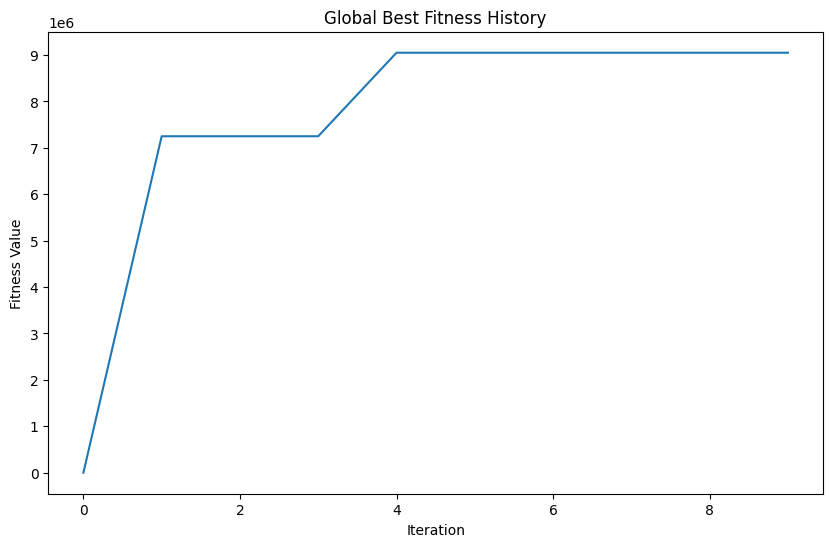

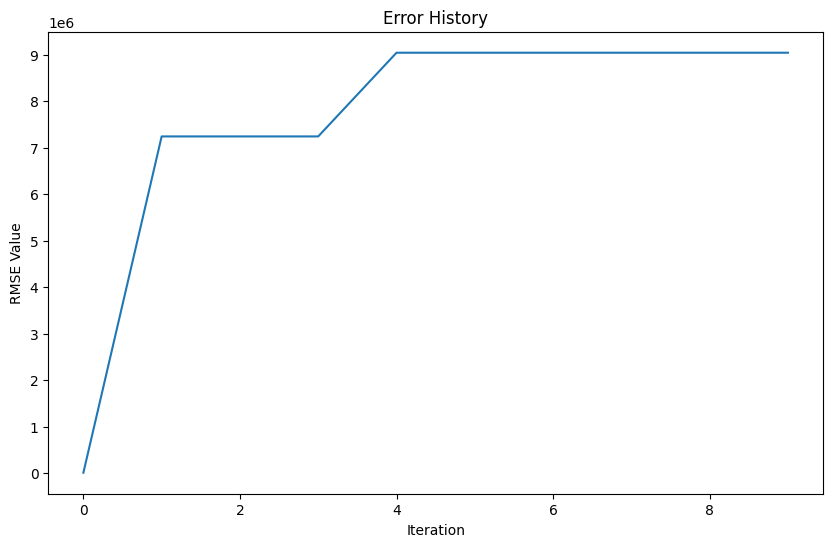

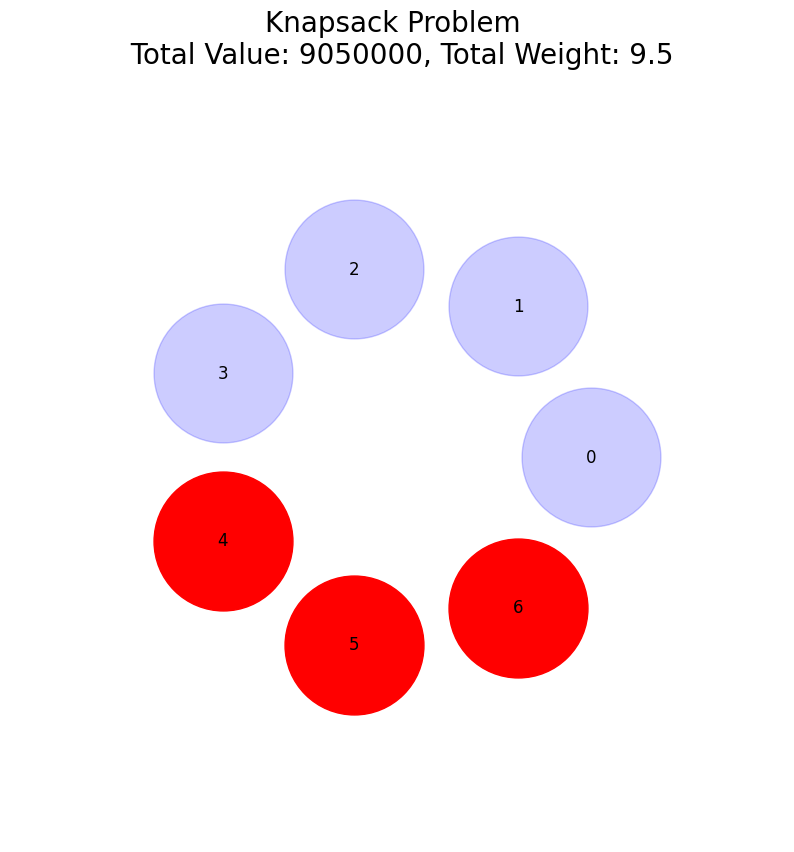

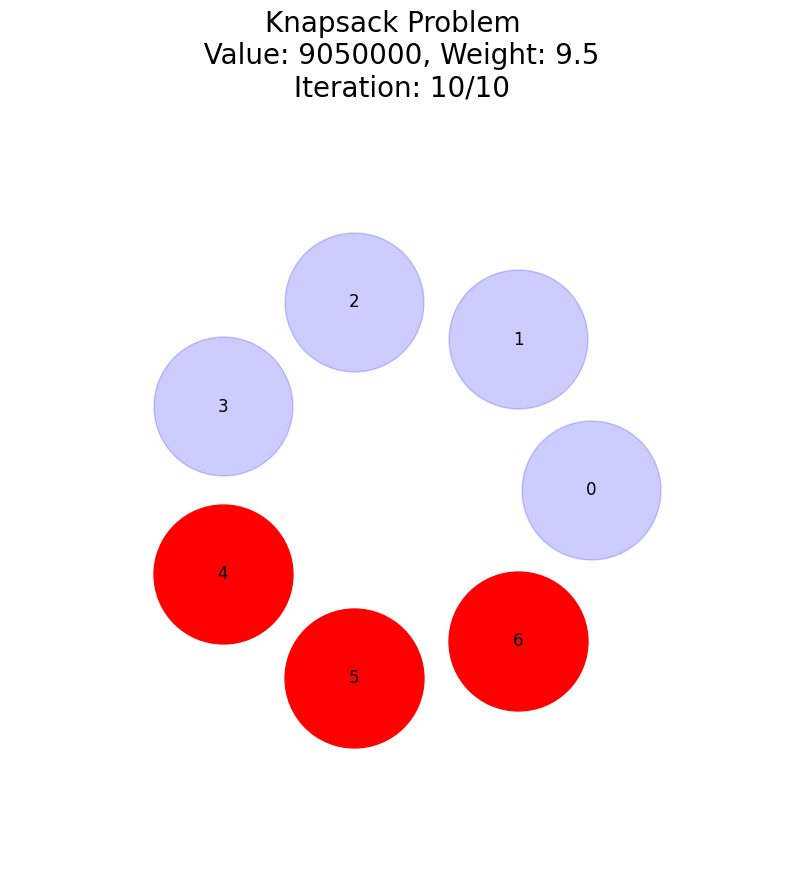

In [36]:
bpso = BPSO(n_particles=5, n_items=n, weights=w, values=v, capacity=W, iterations=10, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
bpso.optimize(verbose=False)
bpso.print_solution()
bpso.plot_fitness()
bpso.plot_error()
bpso.plot_knapsack()
bpso.plot_knapsack_animation(save=True, fps=2)

BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.016577959060668945 seconds
Total iterations: 100

Global best fitness: 9050000
Global best state: [0 0 0 0 1 1 1]

Total weight: 9.5
Total value: 9050000

With:
> item 4 with value 1850000 and weight 1.5
> item 5 with value 3250000 and weight 3
> item 6 with value 3950000 and weight 5


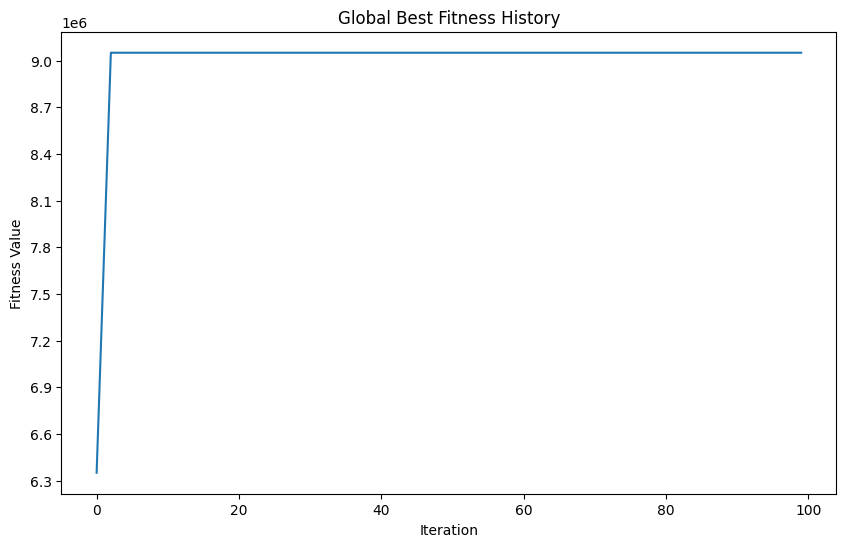

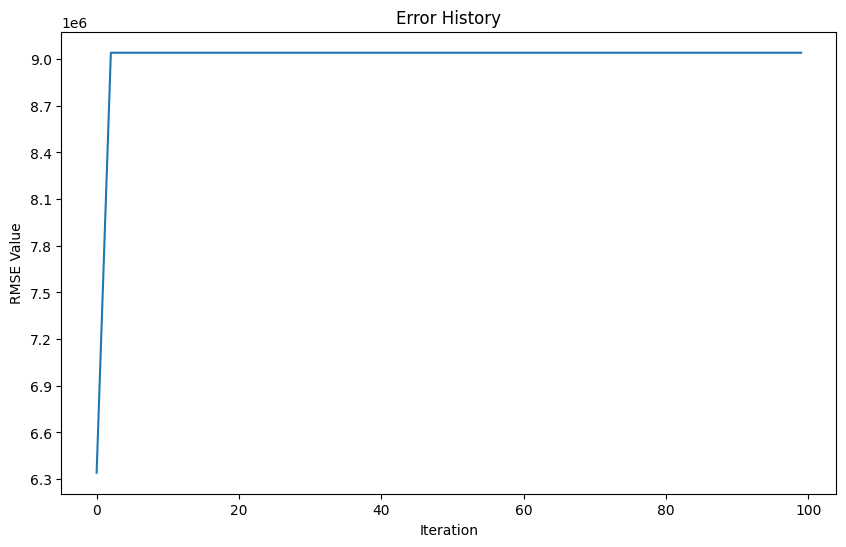

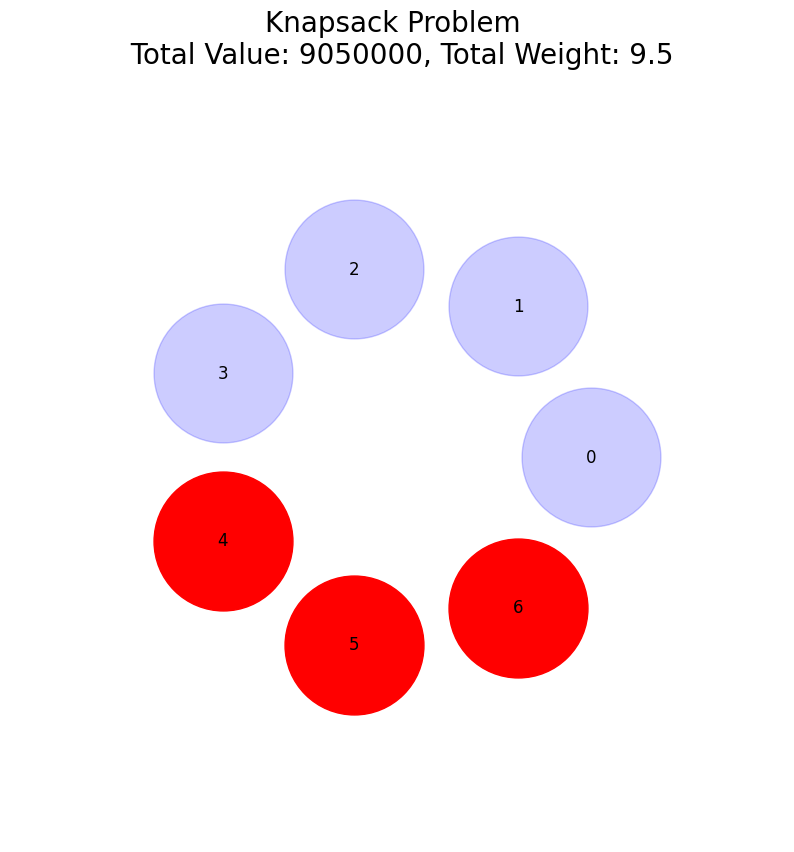

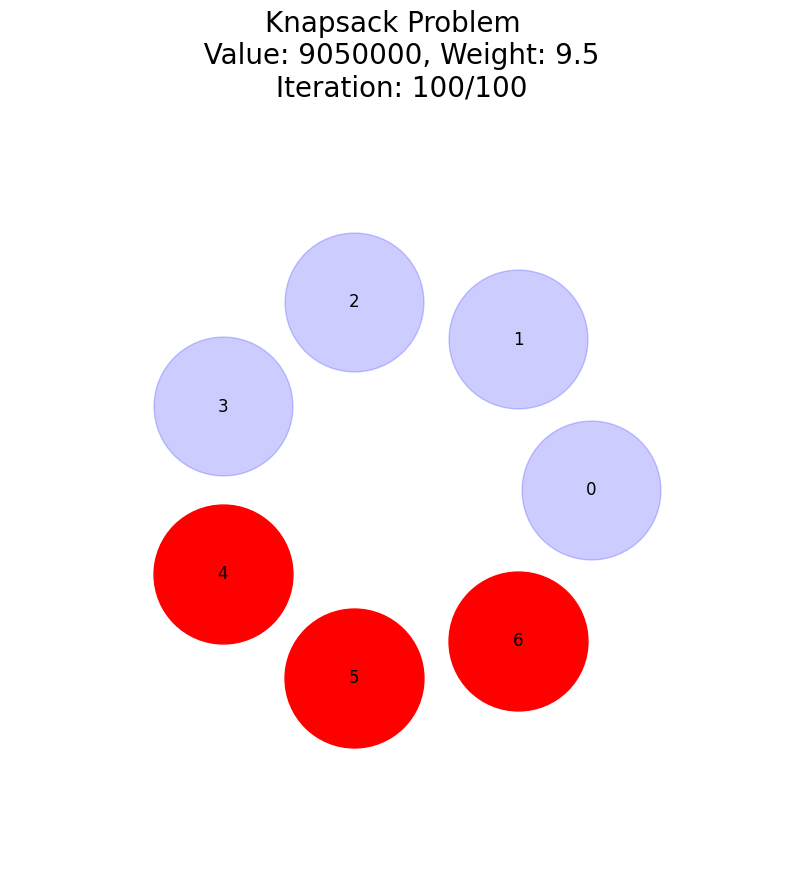

In [37]:
bpso = BPSO(n_particles=10, n_items=n, weights=w, values=v, capacity=W, iterations=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
bpso.optimize(verbose=False)
bpso.print_solution()
bpso.plot_fitness()
bpso.plot_error()
bpso.plot_knapsack()
bpso.plot_knapsack_animation(save=True, fps=10, filename='knapsack_100')

BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.11657214164733887 seconds
Total iterations: 101

Global best fitness: 9050000
Global best state: [0 0 0 0 1 1 1]

Total weight: 9.5
Total value: 9050000

With:
> item 4 with value 1850000 and weight 1.5
> item 5 with value 3250000 and weight 3
> item 6 with value 3950000 and weight 5


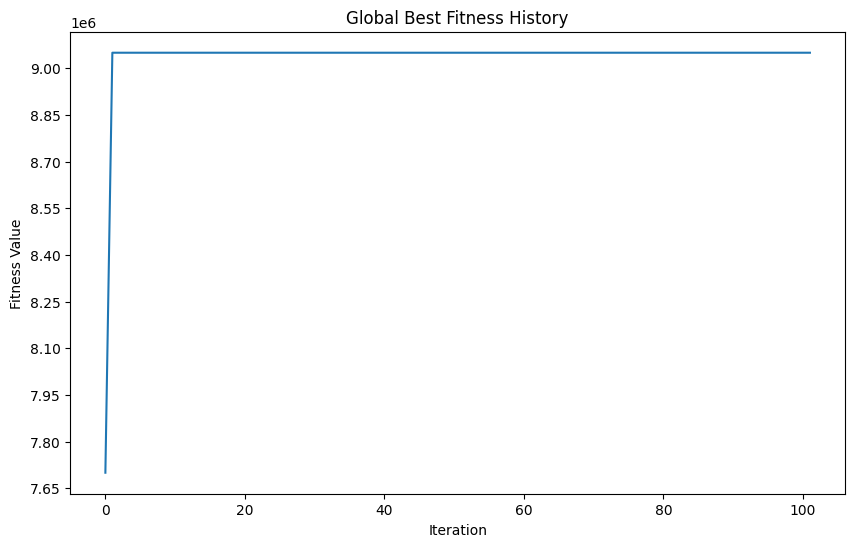

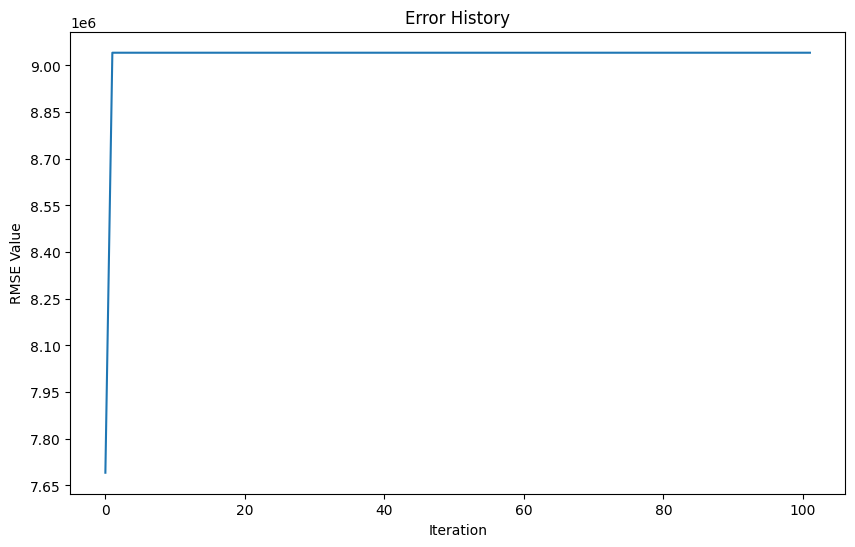

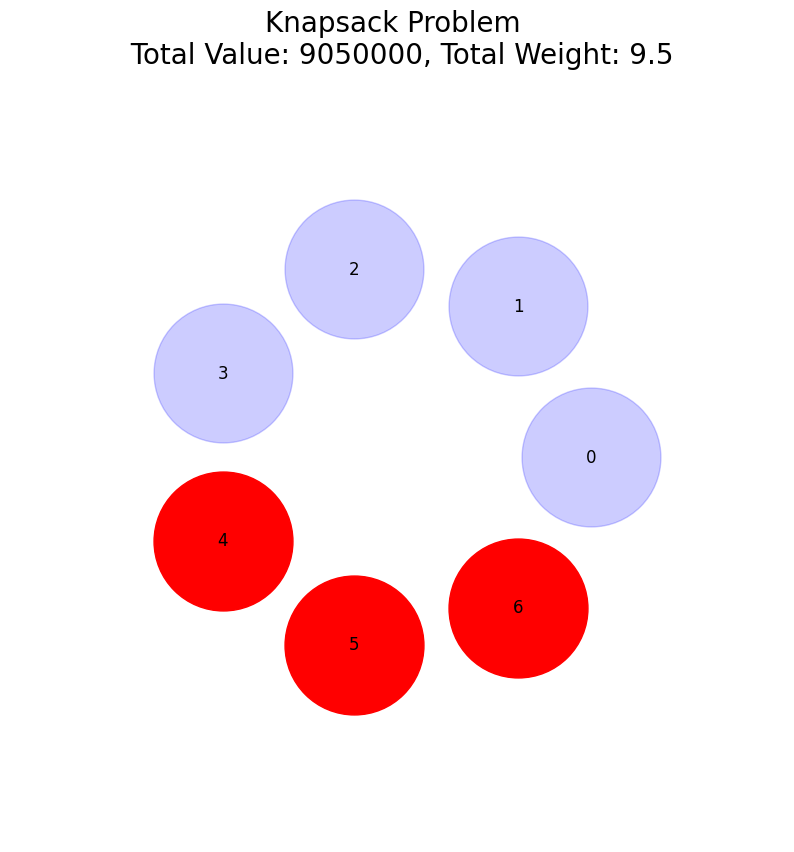

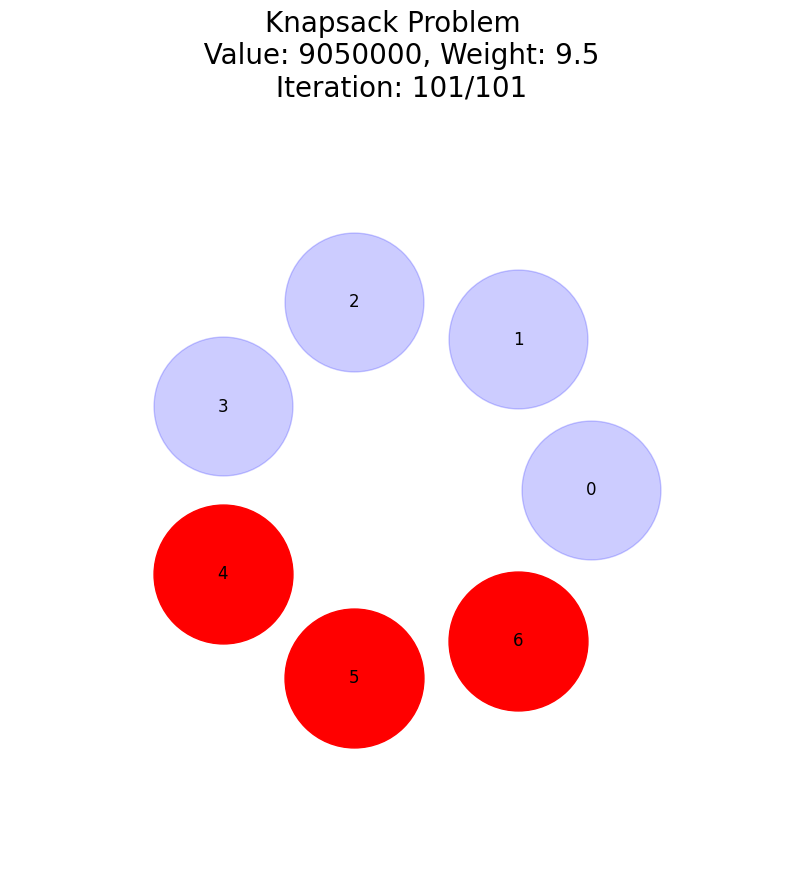

In [38]:
bpso = BPSO(n_particles=100, n_items=n, weights=w, values=v, capacity=W, iterations=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4)
bpso.optimize(verbose=False)
bpso.print_solution()
bpso.plot_fitness()
bpso.plot_error()
bpso.plot_knapsack()
bpso.plot_knapsack_animation(save=True, fps=30, filename='knapsack_1000')

## Consistency test

In [58]:
tests = 100
solution_state = np.array([0, 0, 0, 0, 1, 1, 1])

In [62]:
results_5 = 0

freq = {}
max_freq = 0
most_common_state_5 = None

for i in range(tests):
    
    bpso = BPSO(n_particles=10, n_items=n, weights=w, values=v, capacity=W, iterations=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
    bpso.optimize(verbose=False)
    
    if (bpso.g_best_state == solution_state).all():
        results_5 += 1

    state_tuple = tuple(bpso.g_best_state)
    freq[state_tuple] = freq.get(state_tuple, 0) + 1

    if freq[state_tuple] > max_freq:
        max_freq = freq[state_tuple]
        most_common_state_5 = bpso.g_best_state

print(f'Score: {results_5}/{tests}')
print(f'Most common state: {most_common_state_5}') 

BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.017161846160888672 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.017487049102783203 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.017305374145507812 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.021332502365112305 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.017266273498535156 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.01911330223083496 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.017708778381347656 se

In [41]:
results_10 = 0

freq = {}
max_freq = 0
most_common_state_10 = None

for i in range(tests):
    
    bpso = BPSO(n_particles=10, n_items=n, weights=w, values=v, capacity=W, iterations=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
    bpso.optimize(verbose=False)
    
    if (bpso.g_best_state == solution_state).all():
        results_10 += 1

    state_tuple = tuple(bpso.g_best_state)
    freq[state_tuple] = freq.get(state_tuple, 0) + 1

    if freq[state_tuple] > max_freq:
        max_freq = freq[state_tuple]
        most_common_state_10 = bpso.g_best_state

print(f'Score: {results_10}/{tests}')
print(f'Most common state: {most_common_state_10}')

BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.01398158073425293 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.014730453491210938 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.015269041061401367 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.015357732772827148 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.015457630157470703 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.01494741439819336 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.015717267990112305 sec

In [42]:
results_100 = 0

freq = {}
max_freq = 0
most_common_state_100 = None

for i in range(tests):
    
    bpso = BPSO(n_particles=100, n_items=n, weights=w, values=v, capacity=W, iterations=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
    bpso.optimize(verbose=False)
    
    if (bpso.g_best_state == solution_state).all():
        results_100 += 1

    state_tuple = tuple(bpso.g_best_state)
    freq[state_tuple] = freq.get(state_tuple, 0) + 1

    if freq[state_tuple] > max_freq:
        max_freq = freq[state_tuple]
        most_common_state_100 = bpso.g_best_state

print(f'Score: {results_100}/{tests}')
print(f'Most common state: {most_common_state_100}')

BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.1060006618499756 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.2008533477783203 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.1502296924591064 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.1373684406280518 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.1490671634674072 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.1505475044250488 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.183713436126

In [43]:

import pandas as pd

data = {
    'n_particles': [5, 10, 100],
    'iterations': [10, 100, 1000],
    f'results / {tests}': [results_5, results_10, results_100],
    'most_common_state': [most_common_state_5, most_common_state_10, most_common_state_100]
}

df = pd.DataFrame(data)

In [44]:
df

,n_particles,iterations,results / 100,most_common_state
0,5,10,100,"[0, 0, 0, 0, 1, 1, 1]"
1,10,100,100,"[0, 0, 0, 0, 1, 1, 1]"
2,100,1000,100,"[0, 0, 0, 0, 1, 1, 1]"


## Benchmark Instances

http://artemisa.unicauca.edu.co/~johnyortega/instances_01_KP/

In [45]:
def load_dataset(knapsack, solution):

    n = 0
    W = 0
    v = []
    w = []

    with open(knapsack, 'r') as f:

        line = f.readline().strip().split()
        n = int(line[0])
        W = int(line[1])

        for line in f:
            line = line.strip().split()
            v.append(int(line[0]))
            w.append(int(line[1]))

    v = v[:n]
    w = w[:n]

    optimal = 0

    with open(solution, 'r') as f:
        optimal = int(f.readline().strip())

    return n, W, v, w, optimal

Optimal solution: 1025 with 20 items and capacity 879
DP solution: 1025.0

With:
> item 19 with value 44 and weight 92
> item 18 with value 40 and weight 68
> item 17 with value 78 and weight 32
> item 15 with value 75 and weight 70
> item 13 with value 75 and weight 14
> item 12 with value 63 and weight 58
> item 11 with value 40 and weight 18
> item 10 with value 77 and weight 56
> item 8 with value 61 and weight 25
> item 7 with value 75 and weight 92
> item 6 with value 35 and weight 82
> item 5 with value 8 and weight 6
> item 4 with value 55 and weight 44
> item 3 with value 46 and weight 4
> item 2 with value 90 and weight 43
> item 1 with value 72 and weight 83
> item 0 with value 91 and weight 84

BPSO with parameters: n_particles=100, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.1397099494934082 seconds
Total iterations: 100

Global best fitness: 1025
Global best state: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1]

Total weight: 871
Total value: 1025

With:
> item

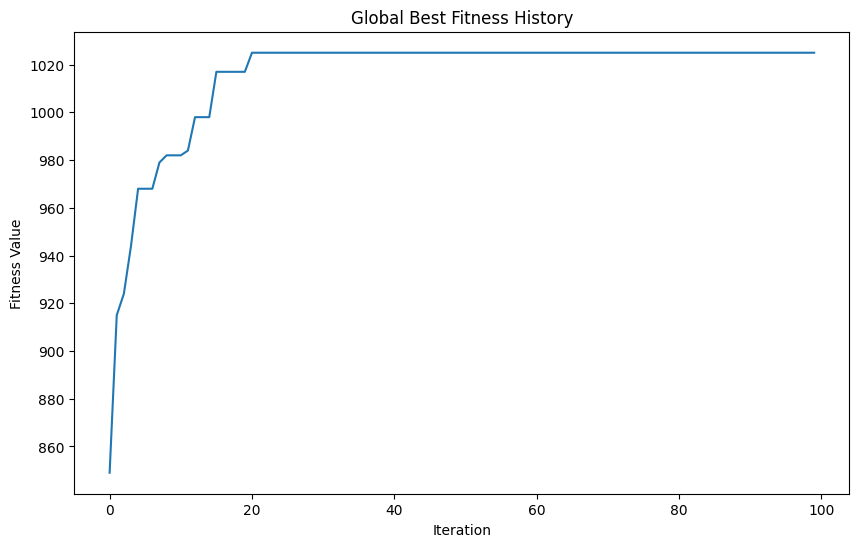

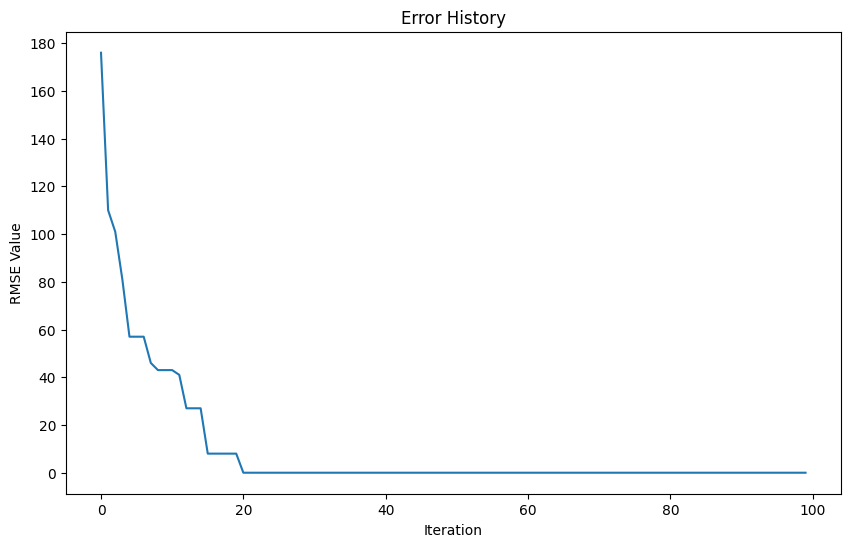

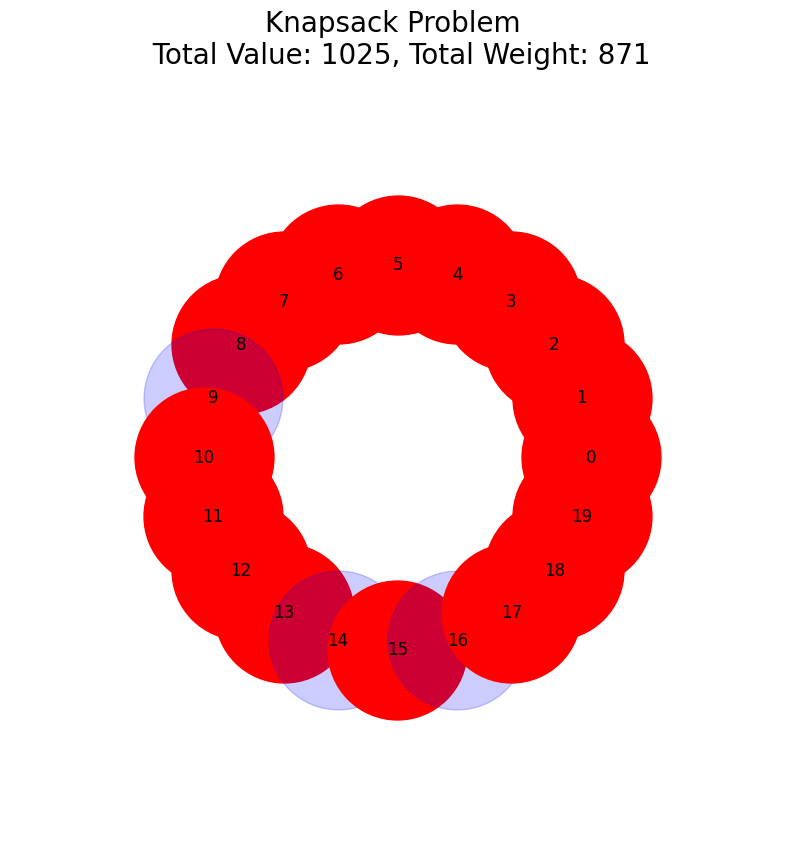

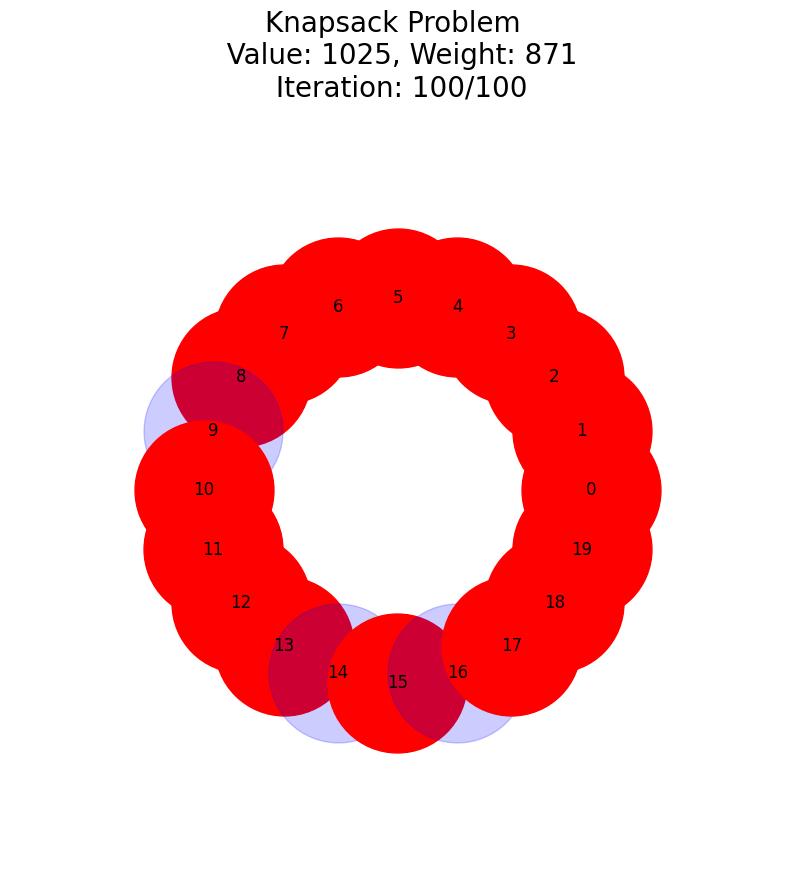

In [46]:
n, W, v, w, optimal = load_dataset(knapsack='data/instances_01_KP/low-dimensional/f10_l-d_kp_20_879', solution='data/instances_01_KP/low-dimensional-optimum/f10_l-d_kp_20_879')
print(f'Optimal solution: {optimal} with {n} items and capacity {W}')

dp, prev = knapsack(w, v, W)
solution = reconstruct(dp, prev, w, v)
best_fitness = dp[-1][-1]

print(f'DP solution: {dp[-1][-1]}')
print()
print('With:')
for i in solution:
    print(f'> item {i} with value {v[i]} and weight {w[i]}')
print()

bpso = BPSO(n_particles=100, n_items=n, weights=w, values=v, capacity=W, iterations=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
bpso.optimize(verbose=False)
bpso.print_solution()
bpso.plot_fitness()
bpso.plot_error()
bpso.plot_knapsack()
bpso.plot_knapsack_animation(save=True, fps=30, filename='benchmark')

## Consistency test 2

In [47]:
tests = 100
solution_state = np.zeros(n)
for i in solution:
    solution_state[i] = 1

In [48]:
results_5 = 0

freq = {}
max_freq = 0
most_common_state_5 = None

for i in range(tests):
    
    bpso = BPSO(n_particles=10, n_items=n, weights=w, values=v, capacity=W, iterations=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
    bpso.optimize(verbose=False)
    
    if (bpso.g_best_state == solution_state).all():
        results_5 += 1

    state_tuple = tuple(bpso.g_best_state)
    freq[state_tuple] = freq.get(state_tuple, 0) + 1

    if freq[state_tuple] > max_freq:
        max_freq = freq[state_tuple]
        most_common_state_5 = bpso.g_best_state

print(f'Score: {results_5}/{tests}')
print(f'Most common state: {most_common_state_5}') 

BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.01805257797241211 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.01576399803161621 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.016849279403686523 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.015477657318115234 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.014704465866088867 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.01474142074584961 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.014685392379760742 seco

In [49]:
results_10 = 0

freq = {}
max_freq = 0
most_common_state_10 = None

for i in range(tests):
    
    bpso = BPSO(n_particles=10, n_items=n, weights=w, values=v, capacity=W, iterations=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
    bpso.optimize(verbose=False)
    
    if (bpso.g_best_state == solution_state).all():
        results_10 += 1

    state_tuple = tuple(bpso.g_best_state)
    freq[state_tuple] = freq.get(state_tuple, 0) + 1

    if freq[state_tuple] > max_freq:
        max_freq = freq[state_tuple]
        most_common_state_10 = bpso.g_best_state

print(f'Score: {results_10}/{tests}')
print(f'Most common state: {most_common_state_10}')

BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.017859220504760742 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.01649022102355957 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.01538705825805664 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.015408515930175781 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.015273571014404297 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.014507055282592773 seconds
Total iterations: 100
BPSO with parameters: n_particles=10, ite=100, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 0.014319419860839844 sec

In [50]:
results_100 = 0

freq = {}
max_freq = 0
most_common_state_100 = None

for i in range(tests):
    
    bpso = BPSO(n_particles=100, n_items=n, weights=w, values=v, capacity=W, iterations=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4, early_stop=False)
    bpso.optimize(verbose=False)
    
    if (bpso.g_best_state == solution_state).all():
        results_100 += 1

    state_tuple = tuple(bpso.g_best_state)
    freq[state_tuple] = freq.get(state_tuple, 0) + 1

    if freq[state_tuple] > max_freq:
        max_freq = freq[state_tuple]
        most_common_state_100 = bpso.g_best_state

print(f'Score: {results_100}/{tests}')
print(f'Most common state: {most_common_state_100}')

BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.208448886871338 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.2533268928527832 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.1984033584594727 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.1959691047668457 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.2181928157806396 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.160639762878418 seconds
Total iterations: 1000
BPSO with parameters: n_particles=100, ite=1000, c1=1.5, c2=1.5, w_max=0.9, w_min=0.4
Time taken: 1.18777155876159

In [51]:

import pandas as pd

data = {
    'n_particles': [5, 10, 100],
    'iterations': [10, 100, 1000],
    f'results / {tests}': [results_5, results_10, results_100],
    'most_common_state': [most_common_state_5, most_common_state_10, most_common_state_100]
}

df = pd.DataFrame(data)

In [52]:
df

,n_particles,iterations,results / 100,most_common_state
0,5,10,13,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ..."
1,10,100,17,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ..."
2,100,1000,100,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ..."
